This notebook takes raw data for 2016 - 2019, transforms it,  
creates feautures, and applies scaling.  
The resulting data is written into seperate folders  
for training, validation & testing in `processed_data_dir`.  
Data is measured at various locations. Here, only those  
locations where most metrics are available are selected.  
Data for each location is written to a seperate csv file.  

In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num , DateFormatter
import matplotlib.dates as mdates
import tensorflow as tf

from src.globals import raw_data_dir, interim_data_dir, processed_data_dir
from src.helpers import SplitScaler
from src.visualization import plot_metrics

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [4]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# load meteo files and concat into one df
dfs = []

for file_ in [f'meteo-20{i}.csv' for i in range(16,20)]:
    df = pd.read_csv(raw_data_dir/file_, sep=';', encoding='latin-1')
    dfs.append(df)

df = pd.concat(dfs)

In [6]:
df.head()

,Messort,Parameter,Zeitpunkt,HMW
0,Salzburg Flughafen,Lufttemperatur [GradC],01.01.2016 00:30,"0,8"
1,Salzburg Flughafen,Lufttemperatur [GradC],01.01.2016 01:00,"1,2"
2,Salzburg Flughafen,Lufttemperatur [GradC],01.01.2016 01:30,"1,2"
3,Salzburg Flughafen,Lufttemperatur [GradC],01.01.2016 02:00,"1,1"
4,Salzburg Flughafen,Lufttemperatur [GradC],01.01.2016 02:30,"1,0"


In [7]:
# change decimal from comma to period and make numeric
df.HMW = df.HMW.str.replace(',','.')
df.HMW = pd.to_numeric(df.HMW, errors='coerce')

In [8]:
# 00:00 is encoded as 24:00
# fix:
# https://stackoverflow.com/questions/43359479/pandas-parsing-2400-instead-of-0000
days = df.Zeitpunkt.str[:2]
days.name = 'day'
months = df.Zeitpunkt.str[3:5]
months.name = 'month'
years = df.Zeitpunkt.str[6:10]
years.name = 'year'

hours = df.Zeitpunkt.str[11:13]
hours.name = 'hour'
minutes = df.Zeitpunkt.str[14:]
minutes.name = 'minute'

times = pd.DataFrame()

for i in [years, months, days, hours, minutes]:
    i = pd.to_numeric(i)
    times = pd.concat([times, i], axis=1)

df.Zeitpunkt = pd.to_datetime(times)

In [9]:
# remove duplicates in index otherwhise unstacking won't work
df.drop_duplicates(subset=['Messort', 'Parameter', 'Zeitpunkt'], inplace=True)

In [10]:
# unstack index to get metrics into columns
df.set_index(['Messort', 'Parameter', 'Zeitpunkt'], inplace=True)
df = df.unstack('Parameter')

In [11]:
# remove multilevel column names
df.columns = df.columns.droplevel()
df.columns.name = None

In [12]:
df.to_pickle(interim_data_dir/'sbg-weather-unstacked.pkl')

# Select data

In [13]:
df = pd.read_pickle(interim_data_dir/'sbg-weather-unstacked.pkl')

In [14]:
# count available metrics per location
overall_counts = pd.DataFrame()

for location in df.index.get_level_values(0).unique():
    counts_per_loc = df.loc[location,:].notna().sum()
    counts_per_loc.name = location
    overall_counts = pd.concat([overall_counts, counts_per_loc], axis=1)

overall_counts = overall_counts.transpose()

In [15]:
overall_counts

,Luftdruck [hPa],Lufttemperatur [GradC],Sonnenscheindauer [min],Windgeschwindigkeit [m/s],Windrichtung [Grad],Windspitze [m/s],rel. Luftfeuchte [%]
Bergheim Siggerwiesen,69951,69548,0,69931,69930,69929,38278
Gaisberg Zistel,0,70107,0,0,0,0,70107
Hallein Eisenbahnbrücke,0,70073,0,70072,70072,70072,70072
Hallein Winterstall,70063,70061,0,70060,70060,70059,70060
Hallein Winterstall I (610 m),0,69456,0,0,0,0,69069
Hallein Winterstall II (700 m),0,69643,0,0,0,0,70108
Hallein Winterstall III (893 m),0,70042,0,0,0,0,70042
Haunsberg,70000,69998,0,69999,69999,69997,67479
Salzburg Fernheizwerk Mitte,0,0,0,70099,68712,70098,0
Salzburg Fernheizwerk Nord,0,0,0,64292,62329,64286,0


In [16]:
# use only locations for which the majority of metrics is available
selected_metrics = ['Luftdruck [hPa]', 'Lufttemperatur [GradC]',
       'Windgeschwindigkeit [m/s]', 'Windrichtung  [Grad]', 'Windspitze [m/s]',
       'rel. Luftfeuchte [%]']

min_counts = overall_counts[selected_metrics].min(axis=1)
selected_locations = min_counts[min_counts>6.9e4].index
selected_locations

Index(['Hallein Winterstall', 'Salzburg Lehener Park',
       'St.Johann - Bezirkshauptmannschaft', 'Zell am See - Eishalle'],
      dtype='object')

In [17]:
df = df.loc[selected_locations, selected_metrics]

# Fill nas

In [18]:
df = df.fillna(method='ffill')

# Feature engineering

In [19]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#feature_engineering

## Wind

In [20]:
wv = df.pop('Windgeschwindigkeit [m/s]')
max_wv = df.pop('Windspitze [m/s]')

# Convert to radians.
wd_rad = df.pop('Windrichtung  [Grad]')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-7.611510228365857,
 10.340481406628184,
 -10.569895942061377,
 7.494262791219212)

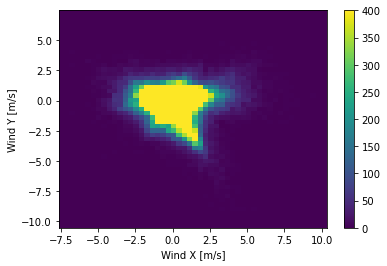

In [21]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

## Month and day as sine & cosine

In [22]:
datetimes = df.index.get_level_values(1)
#datetimes = datetimes.map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
timestamp_s = datetimes.map(datetime.datetime.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

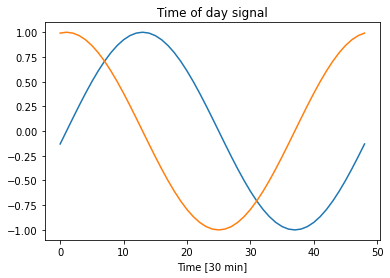

In [23]:
plt.plot(np.array(df['Day sin'])[:49])
plt.plot(np.array(df['Day cos'])[:49])
plt.xlabel('Time [30 min]')
plt.title('Time of day signal')

In [24]:
df.to_pickle(interim_data_dir/'sbg-weather.pkl')

# Visual Exploration

In [25]:
df = pd.read_pickle(interim_data_dir/'sbg-weather.pkl')

# parse date column & set multiindex
#df.Zeitpunkt = pd.to_datetime(df.Zeitpunkt, format='%Y-%m-%d %H:%M:%S')
#df.set_index(['Messort', 'Zeitpunkt'], inplace=True)

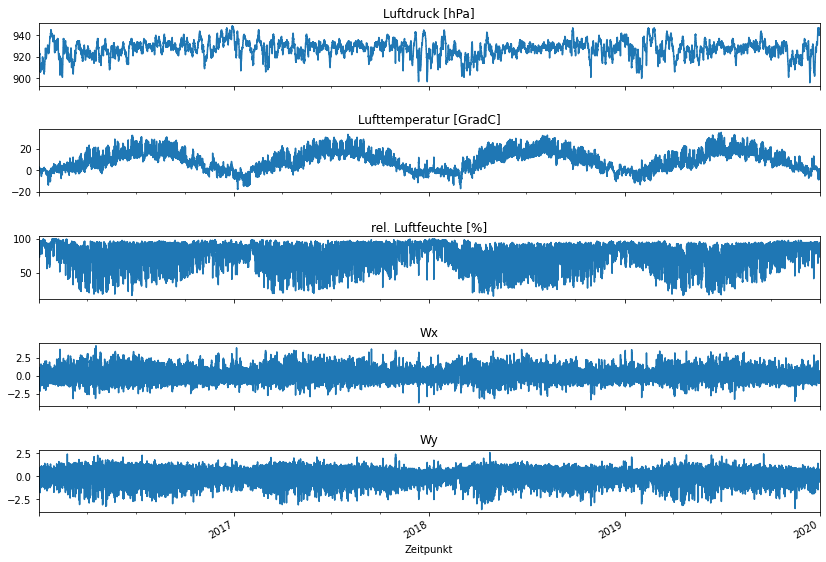

In [26]:
slc = slice('2016', None)
metrics = ['Luftdruck [hPa]', 'Lufttemperatur [GradC]', 'rel. Luftfeuchte [%]',
       'Wx', 'Wy']

plot_metrics(df.loc['Zell am See - Eishalle'], metrics=metrics, selected_slice=slc)

# Train test split & scaling

In [27]:
df = pd.read_pickle(interim_data_dir/'sbg-weather.pkl')

In [28]:
# keep only hourly measures
# (instead of 30 min intervals)
df = df.iloc[1::2]

In [29]:
### encode locations as integers for embeddings
# get unique locations
locations_array = df.index.get_level_values(0)
unique_locations = locations_array.unique()
# assign an index to each location
locations_dict = {name: index for index, name in enumerate(unique_locations)}
# transform locations from index to integer representations
assign_location_int = lambda x: locations_dict[x]
locations = list(map(assign_location_int, locations_array))
locations = pd.Series(locations, index=df.index)

In [40]:
# set what ratio of the data should be used for
# training, validation & testing
train_share = .5
val_share = .25

train_val_ratios = (train_share,val_share)

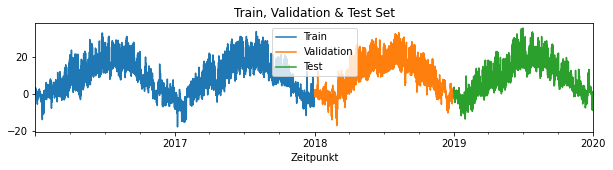

In [41]:
split_scaler = SplitScaler(df, train_val_ratios)
split_scaler.plot()

In [33]:
train_df = split_scaler.train
val_df = split_scaler.val
test_df = split_scaler.test

In [35]:
# assign unscaled location representations
# back to scaled dataframes
train_df['Location'] = locations.loc[pd.IndexSlice[:,split_scaler.train_slice]]
val_df['Location'] = locations.loc[pd.IndexSlice[:,split_scaler.val_slice]]
test_df['Location'] = locations.loc[pd.IndexSlice[:,split_scaler.test_slice]]

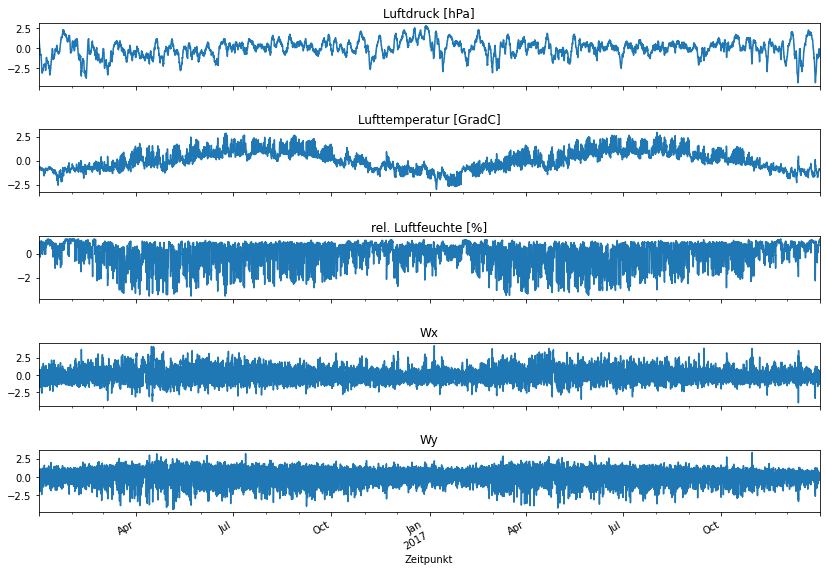

In [36]:
slc = slice('2016', None)
metrics = ['Luftdruck [hPa]', 'Lufttemperatur [GradC]', 'rel. Luftfeuchte [%]',
       'Wx', 'Wy']

plot_metrics(train_df.loc['Zell am See - Eishalle'], metrics=metrics, selected_slice=slc)

In [37]:
dstypes = ['train', 'val', 'test']
datasets = [train_df, val_df, test_df]

for dstype, dataset in zip(dstypes, datasets):
    # create seperate directories for training, 
    # validation & test data
    dstype_dir = processed_data_dir / dstype
    if not dstype_dir.exists():
        dstype_dir.mkdir()

    # write each location
    # to a seperate file
    for location in unique_locations:
        name = location.lower() \
            .replace('.', '') \
            .replace(' - ', '_') \
            .replace(' ', '_') 
        
        name += '.csv'

        dataset.loc[location].to_csv(dstype_dir/name,
            encoding='utf8', index=False)